In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load data
file_path = '/workspaces/BakuDShaggy-EDA-mas-proyecto-final/data/raw/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)

# Initial verification
print("Data Shape:", data.shape)
print("\nClass Balance:")
print(data['Diabetes_binary'].value_counts(normalize=True))
print("\nMissing Values:", data.isnull().sum().sum())

Data Shape: (70692, 22)

Class Balance:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

Missing Values: 0


In [ ]:
# Create interaction feature
data['BP_Chol_Combo'] = data['HighBP'] * data['HighChol']

# Split data
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 80% train, 20% test
    random_state=42,      # Reproducibility
    stratify=y            # Maintain class balance
)


bins = [-1, 7, 14, 30]  
labels = ['0-7_days', '8-14_days', '15-30_days']

for df in [X_train, X_test]:
    df['PhysHlth_grouped'] = pd.cut(df['PhysHlth'], bins=bins, labels=labels, include_lowest=True)
    df.drop('PhysHlth', axis=1, inplace=True)


scaler = StandardScaler()
X_train['BMI_scaled'] = scaler.fit_transform(X_train[['BMI']])
X_test['BMI_scaled'] = scaler.transform(X_test[['BMI']])

# Create full datasets with target
train_data = X_train.copy()
train_data['Diabetes_binary'] = y_train
test_data = X_test.copy()
test_data['Diabetes_binary'] = y_test

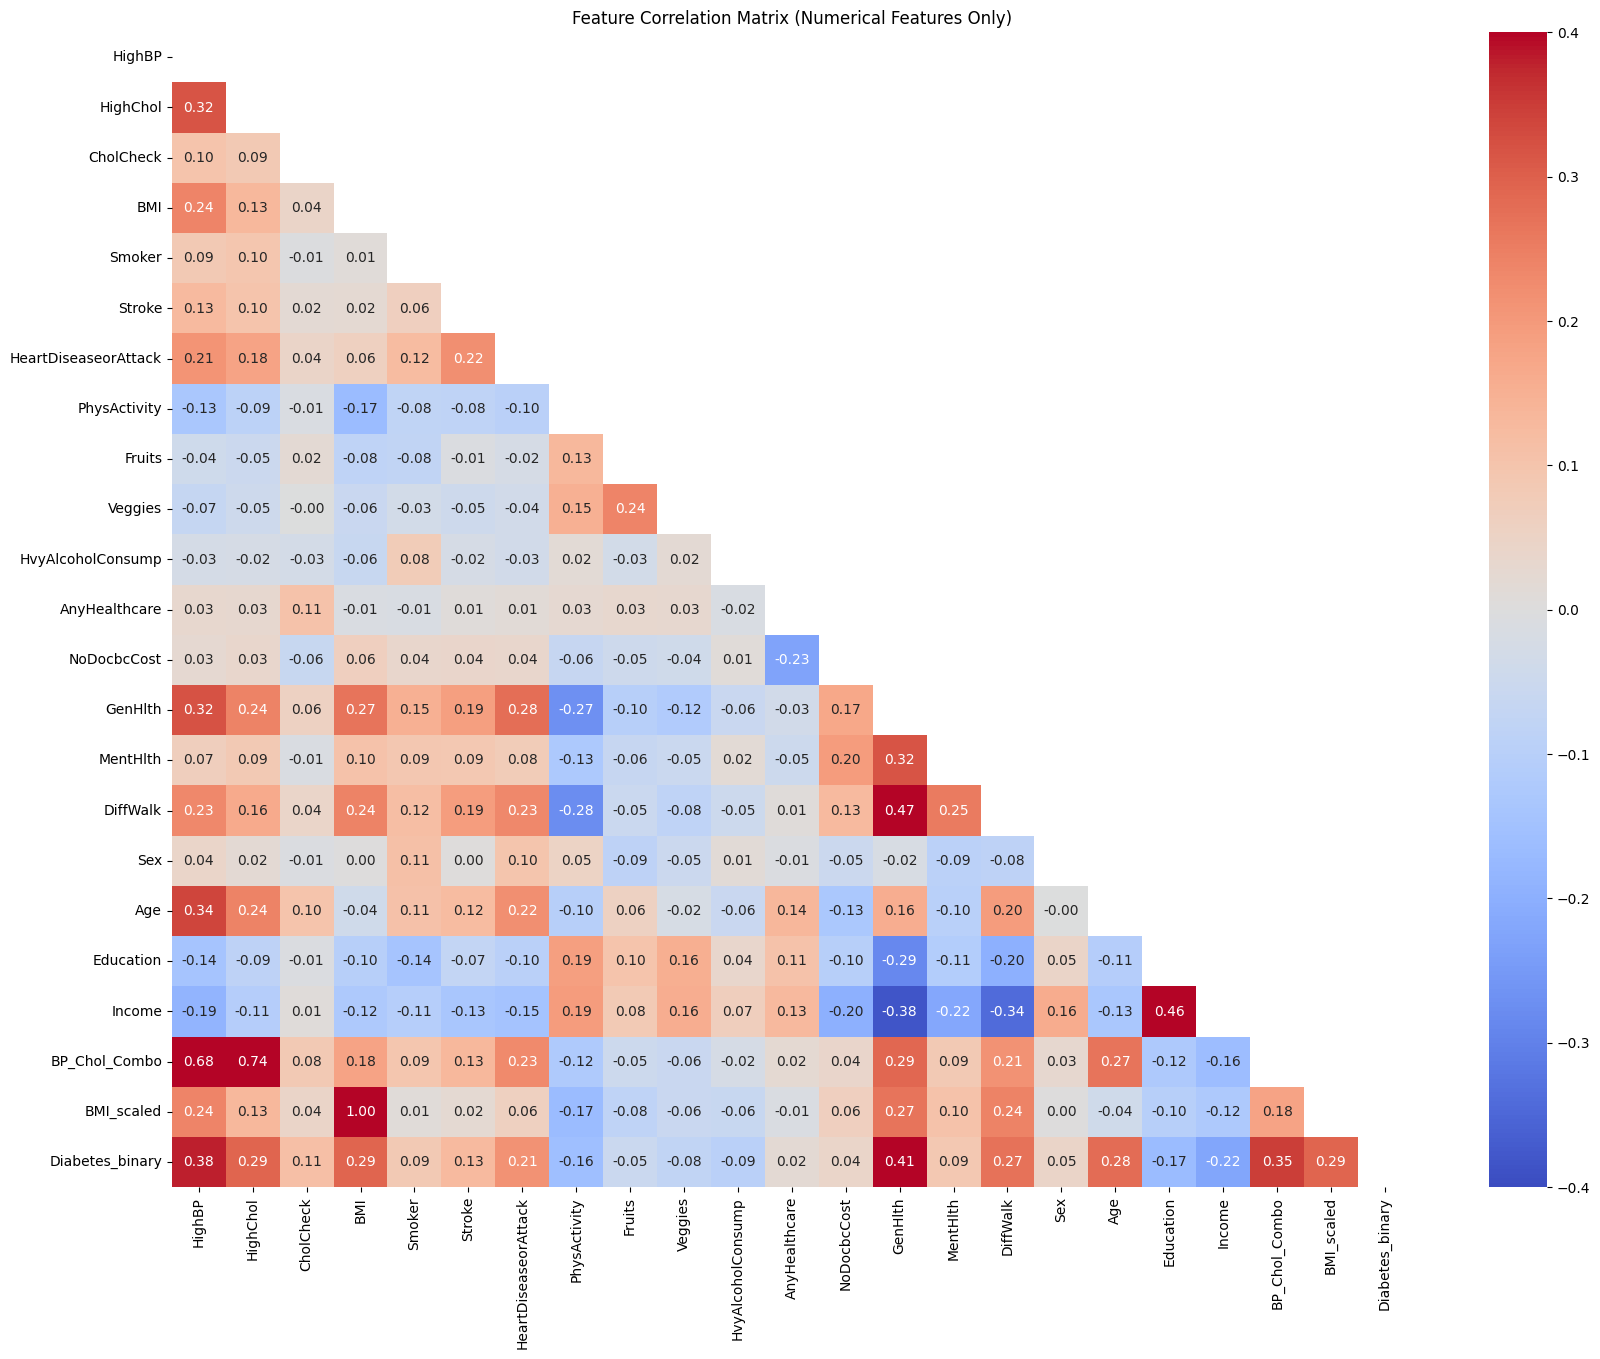

In [3]:
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_data[numerical_cols].corr()

# Plot
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    vmin=-0.4,
    vmax=0.4
)
plt.title("Feature Correlation Matrix (Numerical Features Only)")
plt.show()

In [4]:
# Define ordinal features and their natural order
ordinal_cols = ['GenHlth', 'Education', 'Income', 'Age']
ordinal_categories = [
    [1,2,3,4,5],  # GenHlth: 1=Excellent -> 5=Poor
    [1,2,3,4,5,6],  # Education
    [1,2,3,4,5,6,7,8],  # Income
    list(range(1,14))  # Age (1-13 categories)
]

# Encode features
encoder = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='use_encoded_value', 
    unknown_value=-1  # Special value for unseen categories
)
X_train_ordinal = encoder.fit_transform(X_train[ordinal_cols])
X_test_ordinal = encoder.transform(X_test[ordinal_cols])

In [5]:
# Combine features correctly
X_combined_train = np.hstack([
    X_train_ordinal,  # Encoded ordinal features
    X_train[['HighBP', 'HighChol', 'BMI_scaled', 'BP_Chol_Combo']].values  # Other features
])

# Train model
model = LogisticRegressionCV(
    Cs=20,  # 20 regularization strengths to try
    penalty='elasticnet',  # Mix of L1/L2 regularization
    solver='saga',  # Only solver that works with elasticnet
    l1_ratios=[0.2, 0.5, 0.8],  # Balance between L1/L2
    cv=5,  # 5-fold cross-validation
    max_iter=1000,  # Needed for convergence
    class_weight='balanced'  # Handle slight imbalances
)
model.fit(X_combined_train, y_train)

# Evaluate
y_pred = model.predict(X_combined_train)
print("Training Performance:")
print(classification_report(y_train, y_pred))

Training Performance:
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74     28276
         1.0       0.74      0.76      0.75     28277

    accuracy                           0.74     56553
   macro avg       0.74      0.74      0.74     56553
weighted avg       0.74      0.74      0.74     56553



# Explore here

## Step 1: Problem statement and data collection¶

# The database is about diabetes, the main column is a binary column, with 0 for no diabetes, 1 for pre diabetes or diabetes, the rest is mostly health data about the patient and some non related information or so would it seem.
# First we will load the data, create the test and train

In [2]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
file_path = '/workspaces/BakuDShaggy-EDA-mas-proyecto-final/data/raw/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)

# --- Ordinal Range Check ---
range_check = {}
for col in ['Age', 'Education', 'Income']:
    range_check[col] = (data[col].min(), data[col].max())

print("Feature Ranges:\n", range_check)

# 1. Verify 50/50 balance
print("Class Balance:")
print(data['Diabetes_binary'].value_counts(normalize=True))

# 2. Check missing values
print("\nMissing Values:", data.isnull().sum().sum())

# 3. Confirm binary features
binary_cols = [col for col in data.columns 
               if sorted(data[col].unique()) in [[0,1], [0.0,1.0]]]

print(f"\nBinary Features: {len(binary_cols)}/21 (BMI is continuous)")

print(f"Full dataset shape:{data.shape}")

Feature Ranges:
 {'Age': (np.float64(1.0), np.float64(13.0)), 'Education': (np.float64(1.0), np.float64(6.0)), 'Income': (np.float64(1.0), np.float64(8.0))}
Class Balance:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

Missing Values: 0

Binary Features: 15/21 (BMI is continuous)
Full dataset shape:(70692, 22)


### Data Verification

1. **Balanced Data Confirmed**
✅ Perfect 50/50 Split
*No class imbalance issues in modeling ensured*

2. **Missing Values Check**
- No null Values


In [3]:
data['BP_Chol_Combo'] = data['HighBP'] * data['HighChol']
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 80% train, 20% test
    random_state=42,
    stratify=y 
)
train_data = X_train.copy()
train_data['Diabetes_binary'] = y_train

test_data = X_test.copy()
test_data['Diabetes_binary'] = y_test

print(f"\nTrain shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")


Train shape: (56553, 23)
Test shape: (14139, 23)


## Ordinal Feature Distributions

,Age,Education,Income,GenHlth,MentHlth
count,56553.00,56553.00,56553.00,56553.00,56553.00
mean,8.58,4.92,5.70,2.83,3.73
std,2.85,1.03,2.17,1.11,8.12
min,1.00,1.00,1.00,1.00,0.00
25%,7.00,4.00,4.00,2.00,0.00
50%,9.00,5.00,6.00,3.00,0.00
75%,11.00,6.00,8.00,4.00,2.00
max,13.00,6.00,8.00,5.00,30.00


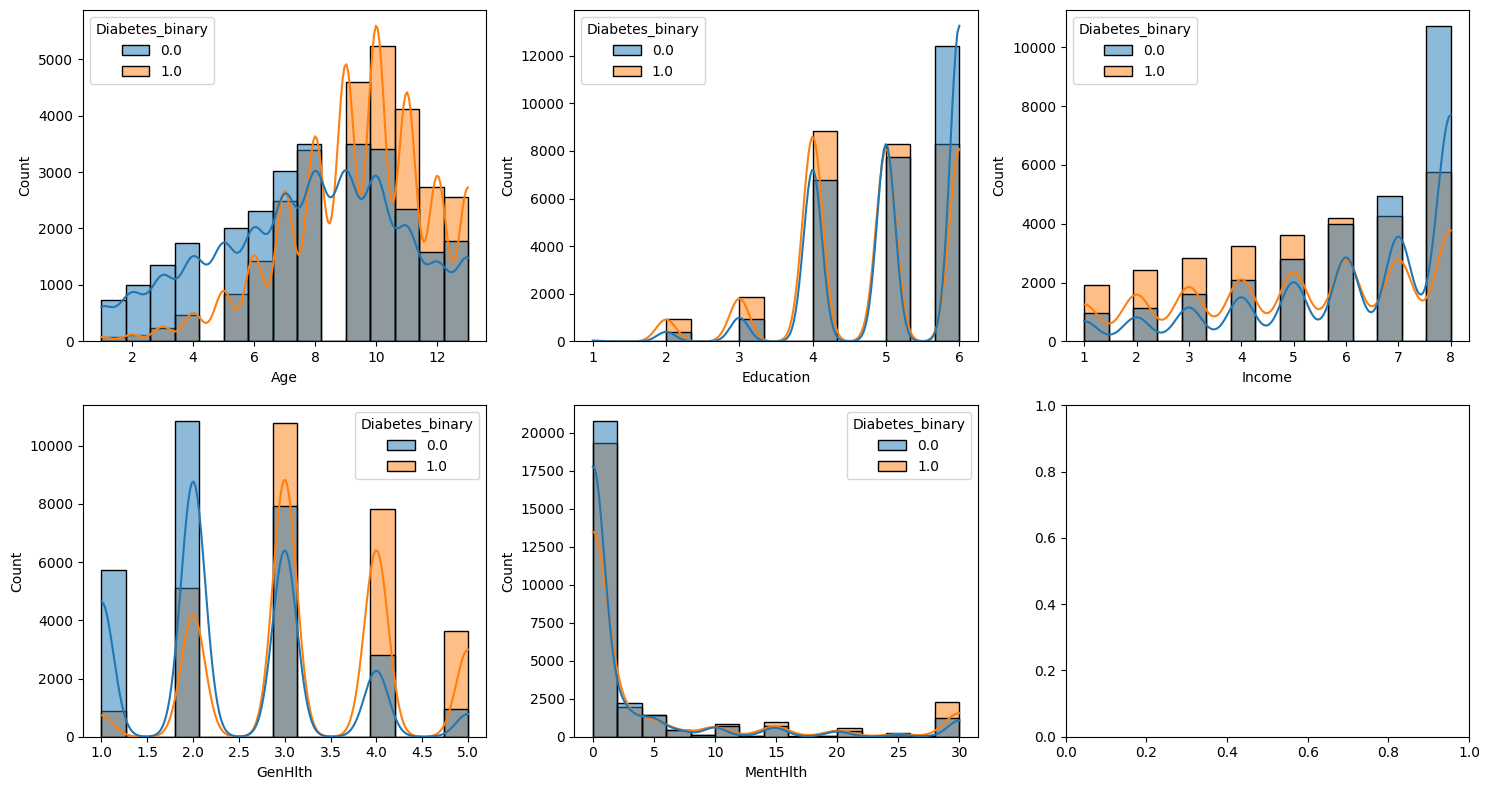

In [5]:
# --- Ordinal Feature Distributions ---
ordinal_cols = ['Age', 'Education', 'Income', 'GenHlth', 'MentHlth']
display(train_data[ordinal_cols].describe().apply(lambda x: round(x, 2)))

# Generate histograms for ordinal features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(ordinal_cols):
    sns.histplot(data=train_data, x=col, hue='Diabetes_binary', ax=axes[i//3, i%3], kde=True, bins=15)
plt.tight_layout()

PhysHlth_grouped in train_data: True

PHYSHEALTH GROUP ANALYSIS
Distribution:
PhysHlth_grouped
0-7_days      0.485670
15-30_days    0.405797
8-14_days     0.108533
Name: proportion, dtype: float64

Diabetes Rates:
Diabetes_binary        0.0       1.0
PhysHlth_grouped                    
0-7_days          0.485583  0.514417
8-14_days         0.365716  0.634284
15-30_days        0.291433  0.708567
PhysHlth Group Distribution:
PhysHlth_grouped
0-7_days      48.6
15-30_days    40.6
8-14_days     10.9
Name: proportion, dtype: float64

Diabetes Rate by Group:
 Diabetes_binary    0.0   1.0
PhysHlth_grouped            
0-7_days          48.6  51.4
8-14_days         36.6  63.4
15-30_days        29.1  70.9
Train Set After Binning:
PhysHlth_grouped
0-7_days      11930
15-30_days     9968
8-14_days      2666
Name: count, dtype: int64

Test Set After Binning:
PhysHlth_grouped
0-7_days      2944
15-30_days    2569
8-14_days      700
Name: count, dtype: int64


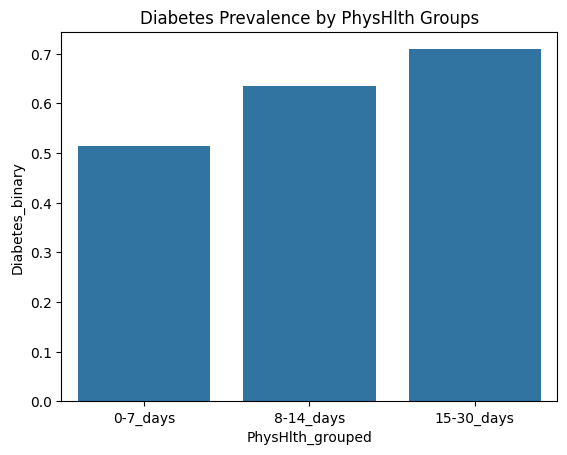

In [6]:
# PhysHlth Binning
bins = [0, 7, 14, 30]
labels = ['0-7_days', '8-14_days', '15-30_days']

# Apply to ORIGINAL DATA
for df in [X_train, X_test]:
    df['PhysHlth_grouped'] = pd.cut(df['PhysHlth'], bins=bins, labels=labels)
    df.drop('PhysHlth', axis=1, inplace=True)


train_data = X_train.copy()
train_data['Diabetes_binary'] = y_train
test_data = X_test.copy()
test_data['Diabetes_binary'] = y_test

# Verify in original data
print("PhysHlth_grouped in train_data:", 'PhysHlth_grouped' in train_data.columns)

# ==== VALIDATION CODE ====
print("\nPHYSHEALTH GROUP ANALYSIS")
print("Distribution:")
print(train_data['PhysHlth_grouped'].value_counts(normalize=True))

print("\nDiabetes Rates:")
print(pd.crosstab(train_data['PhysHlth_grouped'], 
                train_data['Diabetes_binary'], 
                normalize='index'))
  

# --- Validate PhysHlth Binning ---
# Distribution check
physhealth_dist = train_data['PhysHlth_grouped'].value_counts(normalize=True).mul(100).round(1)
print(f"PhysHlth Group Distribution:\n{physhealth_dist}")

# Diabetes rate comparison
ct = pd.crosstab(train_data['PhysHlth_grouped'], train_data['Diabetes_binary'], normalize='index')*100
print("\nDiabetes Rate by Group:\n", ct.round(1))

# Visual confirmation
sns.barplot(x='PhysHlth_grouped', y='Diabetes_binary', data=train_data, errorbar=None)
plt.title("Diabetes Prevalence by PhysHlth Groups");

# Verification
print("Train Set After Binning:")
print(X_train['PhysHlth_grouped'].value_counts())
print("\nTest Set After Binning:")
print(X_test['PhysHlth_grouped'].value_counts())

In [7]:
# Check first few rows
print("\nFirst 3 rows of training data:")
print(train_data.head(3))

# Basic info
print("\nData types:")
print(train_data.dtypes)

# Check class balance
print("\nClass distribution:")
print(train_data['Diabetes_binary'].value_counts(normalize=True))

# Basic statistics
print("\nDescriptive statistics:")
print(train_data.describe())


First 3 rows of training data:
       HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
47977     1.0       0.0        1.0  29.0     1.0     0.0   
2676      0.0       1.0        1.0  24.0     1.0     0.0   
35637     1.0       0.0        1.0  42.0     1.0     0.0   

       HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  GenHlth  \
47977                   0.0           1.0     1.0      1.0  ...      2.0   
2676                    0.0           1.0     0.0      1.0  ...      3.0   
35637                   0.0           1.0     1.0      1.0  ...      3.0   

       MentHlth  DiffWalk  Sex   Age  Education  Income  BP_Chol_Combo  \
47977       0.0       0.0  1.0  10.0        6.0     8.0            0.0   
2676       15.0       0.0  0.0   7.0        5.0     1.0            0.0   
35637       0.0       1.0  0.0  11.0        5.0     4.0            0.0   

       PhysHlth_grouped  Diabetes_binary  
47977               NaN              1.0  
2676           0-7_days              0.

In [8]:
plt.figure(figsize=(20,15))
corr_matrix = train_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    vmin=-0.4,
    vmax=0.4
)
plt.title("Feature Correlation Matrix")
plt.show()


ValueError: could not convert string to float: '0-7_days'

<Figure size 2000x1500 with 0 Axes>

## Feature Importance via Mutual Information

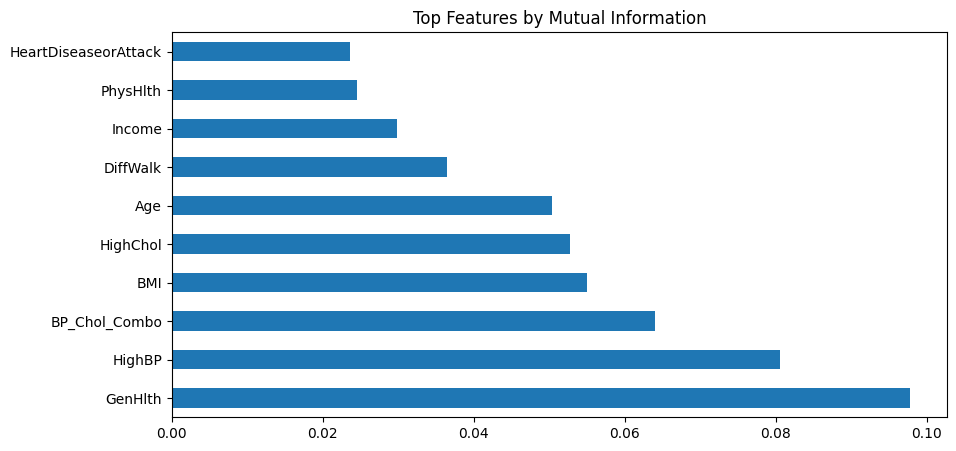

In [ ]:
# --- Mutual Information Calculation ---
from sklearn.feature_selection import mutual_info_classif

# Calculate MI scores (ensure X_train/y_train are defined)
mi = mutual_info_classif(X_train, y_train, discrete_features='auto')
mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,5))
mi_scores.head(10).plot(kind='barh', title='Top Features by Mutual Information');

In [ ]:
print("\nMissing values in training set:")
print(train_data.isnull().sum().sort_values(ascending=False))

print("\nMissing values in test set:")
print(test_data.isnull().sum().sort_values(ascending=False))


Missing values in training set:
PhysHlth_grouped        31989
HighChol                    0
HighBP                      0
BMI                         0
Smoker                      0
Stroke                      0
CholCheck                   0
HeartDiseaseorAttack        0
PhysActivity                0
Veggies                     0
Fruits                      0
AnyHealthcare               0
NoDocbcCost                 0
GenHlth                     0
HvyAlcoholConsump           0
MentHlth                    0
DiffWalk                    0
Age                         0
Sex                         0
Education                   0
Income                      0
BP_Chol_Combo               0
Diabetes_binary             0
dtype: int64

Missing values in test set:
PhysHlth_grouped        7926
HighChol                   0
HighBP                     0
BMI                        0
Smoker                     0
Stroke                     0
CholCheck                  0
HeartDiseaseorAttack       0
Phy

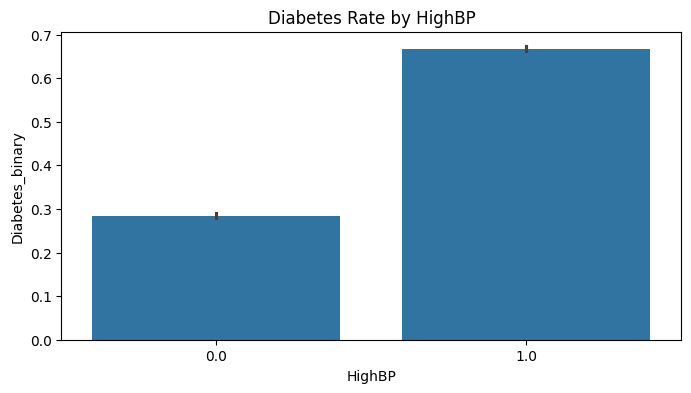

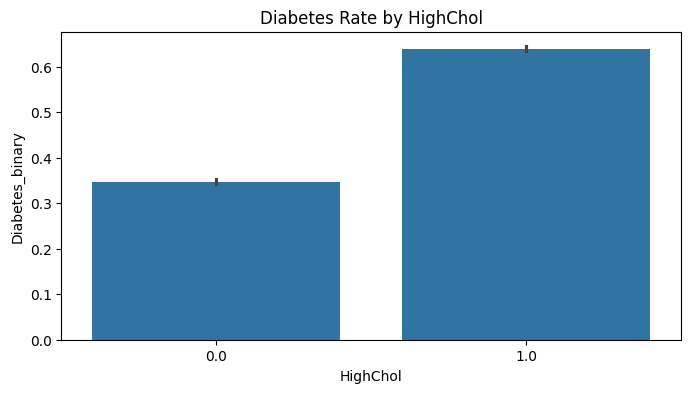

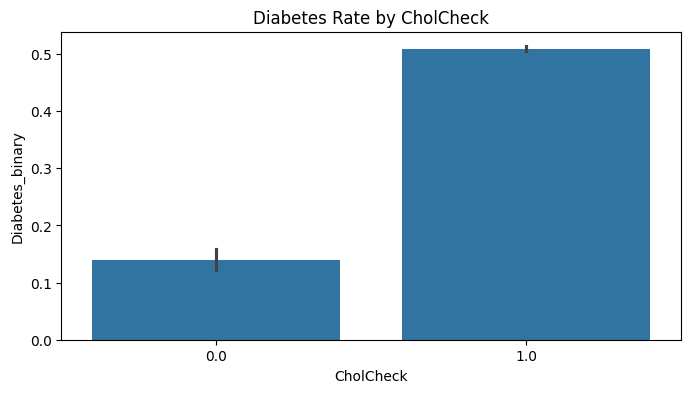

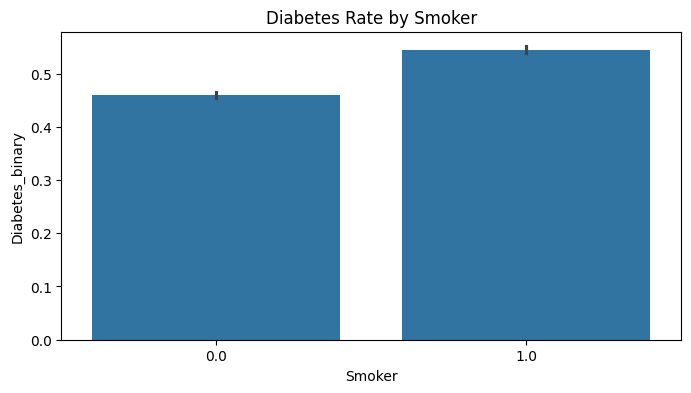

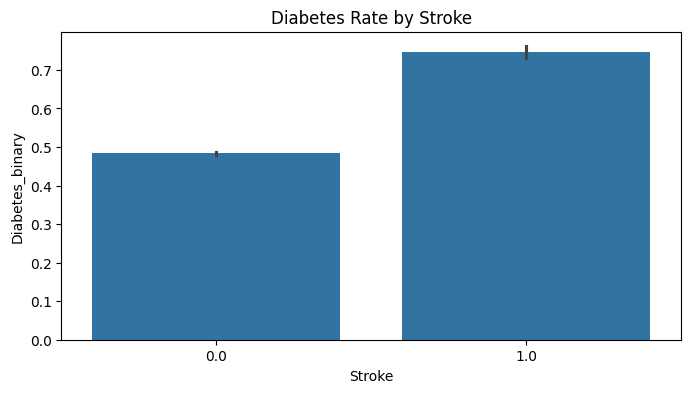

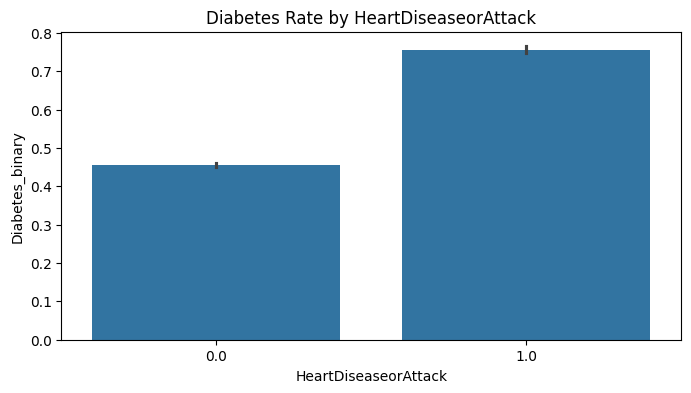

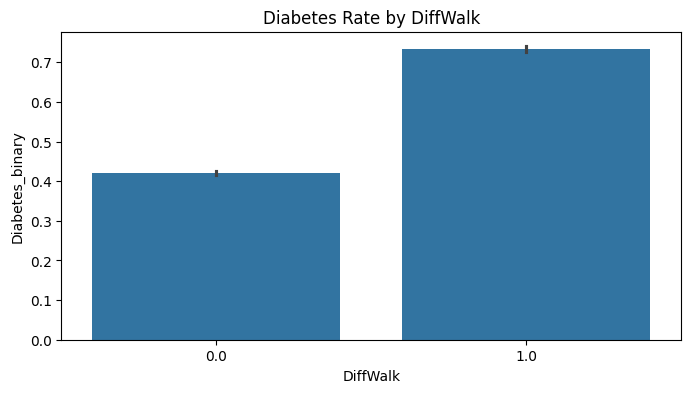

KeyError: 'PhysHlth'

In [ ]:
def plot_feature(feature):
    plt.figure(figsize=(8,4))
    sns.barplot(x=feature, y='Diabetes_binary', data=train_data)
    plt.title(f'Diabetes Rate by {feature}')
    plt.show()

plot_feature('HighBP')       
plot_feature('HighChol')     
plot_feature('CholCheck')
plot_feature('Smoker')
plot_feature('Stroke')
plot_feature('HeartDiseaseorAttack')
plot_feature('DiffWalk')
bins = [0, 7, 14, 30]
labels = ['0-7 days', '8-14 days', '15-30 days']

for df in [train_data, test_data]:
    df['PhysHlth_grouped'] = pd.cut(df['PhysHlth'], bins=bins, labels=labels)
    df.drop('PhysHlth', axis=1, inplace=True)

# Plot the grouped version
plt.figure(figsize=(10,6))
sns.barplot(x='PhysHlth_grouped', y='Diabetes_binary', data=train_data)
plt.title("Diabetes Rate by Grouped Physical Health Days")
plt.show()

# BMI Analysis
plt.figure(figsize=(12,6))
sns.boxplot(x='Diabetes_binary', y='BMI', data=train_data)
plt.title("BMI Distribution by Diabetes Status")
plt.xlabel("Diabetes (0=No, 1=Yes)")
plt.show()

# Feature Interaction
plt.figure(figsize=(10,6))
sns.barplot(x='HighBP', y='Diabetes_binary', hue='HighChol', data=train_data)
plt.title("Diabetes Rates by High BP & Cholesterol Combination")
plt.show()


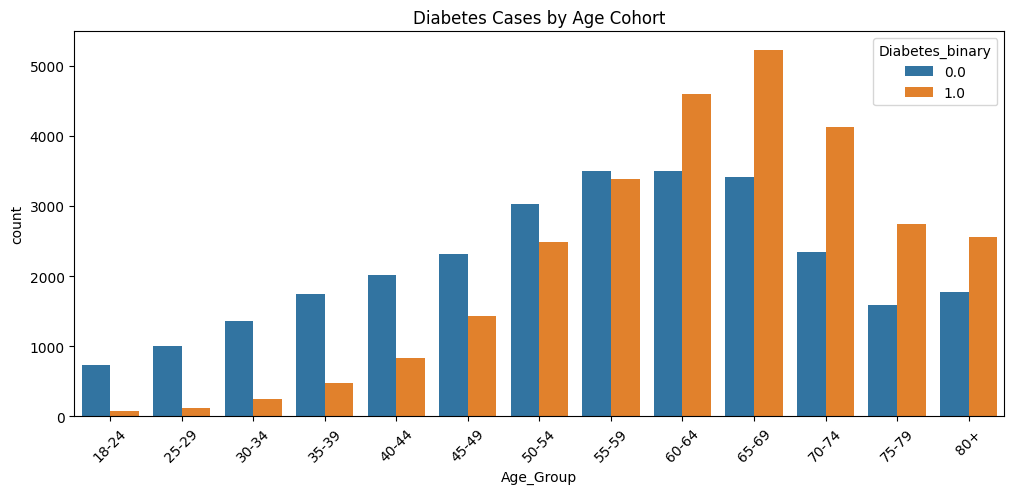

In [ ]:
# Age Stratification Analysis
# --- Age Group Conversion ---
age_groups = {
    1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39',
    5: '40-44', 6: '45-49', 7: '50-54', 8: '55-59',
    9: '60-64', 10: '65-69', 11: '70-74', 12: '75-79',
    13: '80+'
}

train_data['Age_Group'] = train_data['Age'].map(age_groups)

# Plot
plt.figure(figsize=(12,5))
sns.countplot(x='Age_Group', hue='Diabetes_binary', data=train_data, order=list(age_groups.values()))
plt.xticks(rotation=45)
plt.title("Diabetes Cases by Age Cohort");

## Preprocessing Pipeline

In [ ]:


from sklearn.preprocessing import OrdinalEncoder

# Define categories in ASCENDING order of severity
ordinal_cols = ['GenHlth', 'Education', 'Income', 'Age']
ordinal_categories = [
    [1,2,3,4,5],  # GenHlth: 1=Excellent, 5=Poor (natural order)
    [1,2,3,4,5,6],  # Education
    [1,2,3,4,5,6,7,8],  # Income
    list(range(1,14))  # Age
]

encoder = OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ordinal = encoder.fit_transform(X_train[ordinal_cols])
X_test_ordinal = encoder.transform(X_test[ordinal_cols])

In [ ]:
# Baseline Model
# --- Logistic Regression with ElasticNet ---
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report

# Combine ALL features
X_combined_train = np.hstack([
    X_train_ordinal,  # From encoder
    train_data[['HighBP', 'HighChol', 'BMI_scaled', 'BP_Chol_Combo']].values
])

# Train model
model = LogisticRegressionCV(
    Cs=20,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.2, 0.5, 0.8],
    cv=5,
    max_iter=1000,
    class_weight='balanced'
)
model.fit(X_combined_train, y_train)

# Evaluate
y_pred = model.predict(X_combined_train)
print(classification_report(y_train, y_pred))

KeyError: "['BMI_scaled'] not in index"